# Lista 1 - Modelagem e avaliação 



## Questão 1





1. Escreva um shell script que colete informações a cada 5 segundos sobre o seu
navegador, coletando quantos % da CPU, ele está consumindo, qual CPU ele está
executando, e quantos kbytes por segundo (kB wr/s) seu navegador está escrevendo
no disco (dica: pidstat). Nesse mesmo script colete informações do estado geral da sua
máquina (total da RAM que está livre, total da RAM usada, total da RAM reservada
para buffer e para cache). Salve toda a coleta em um arquivo do tipo .csv.


Bash utilizado:

```bash
#!/bin/bash

tempo=0
time_between_calls=5

# pegar estatísticas por 10 minutos
# 10*60 = 600 segundos => 600/5 = 120 ciclos
cicles=120

output_file='log-lista1.csv'

# pegar o pid do primeiro processo do chorme
pid=$(ps aux | grep chrome | awk '{print $2}' | head -n 1)

# adicionar header
echo "time;cpu_per;cpu_core;read_per_s;ram_used;ram_free;ram_buff_cache" > $output_file

while [ $tempo -lt $cicles ]
do  
    # pegar informacoes
    time=$(uptime | awk '{print $1}')
    cpu_per=$(pidstat -p $pid | tail -n 1 | awk '{print $9}')
    cpu_core=$(pidstat -p $pid | tail -n 1 | awk '{print $10}')
    read_per_s=$(pidstat -p $pid -d | tail -n 1 | awk '{print $6}')
    ram_used=$(free -m | awk '/Mem/{print $3}')
    ram_free=$(free -m | awk '/Mem/{print $4}')
    ram_buff_cache=$(free -m | awk '/Mem/{print $6}')

    # colocar as informações no output
    echo "$time;$cpu_per;$cpu_core;$read_per_s;$ram_used;$ram_free;$ram_buff_cache" >> $output_file

    # delay
    sleep $time_between_calls
    tempo=$((tempo+1))
done

echo "Done"

```

Fluxograma:

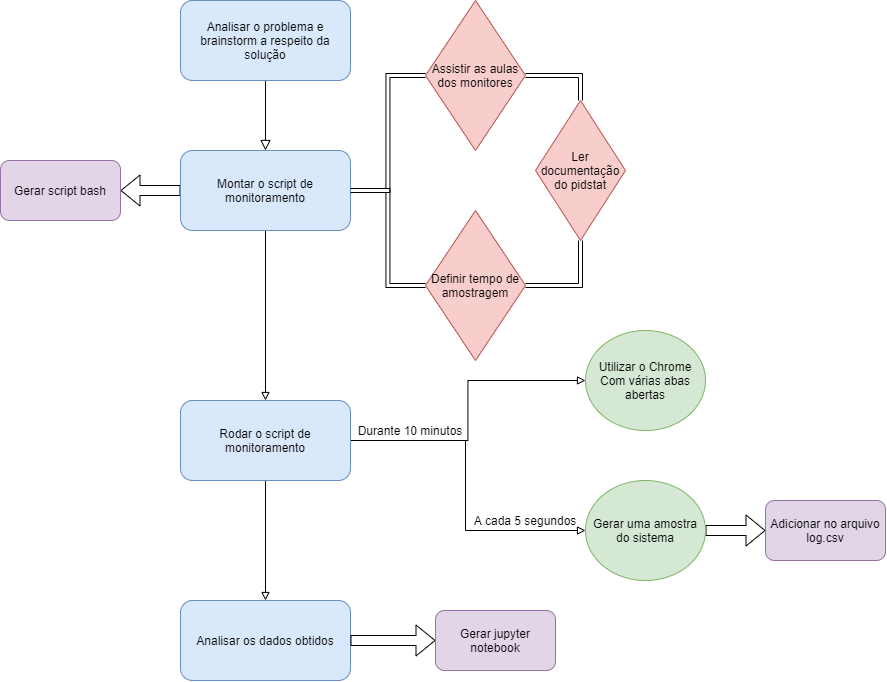

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Apply the default theme
sns.set_theme()

Pegando os dados do github obtidos durante a fase de testes

Repositório: https://github.com/Valgueiro/modelagem/tree/main


In [ ]:
url = 'https://raw.githubusercontent.com/Valgueiro/modelagem/main/lista1/log-lista1.csv?raw=true'
data = pd.read_csv(url, sep=';')
data["time"] = pd.to_datetime(data['time'])
data.head()

,time,cpu_per,cpu_core,read_per_s,ram_used,ram_free,ram_buff_cache
0,2021-03-04 17:28:16,5.24,2,218.55,4051,8826,2973
1,2021-03-04 17:28:21,5.24,2,218.17,4062,8825,2963
2,2021-03-04 17:28:26,5.23,1,217.82,4057,8821,2972
3,2021-03-04 17:28:31,5.24,3,217.45,4113,8739,2998
4,2021-03-04 17:28:36,5.27,1,217.05,4115,8715,3021


### CPU

Analisando o comportamento da utilização de cada em cada um dos cores do processador

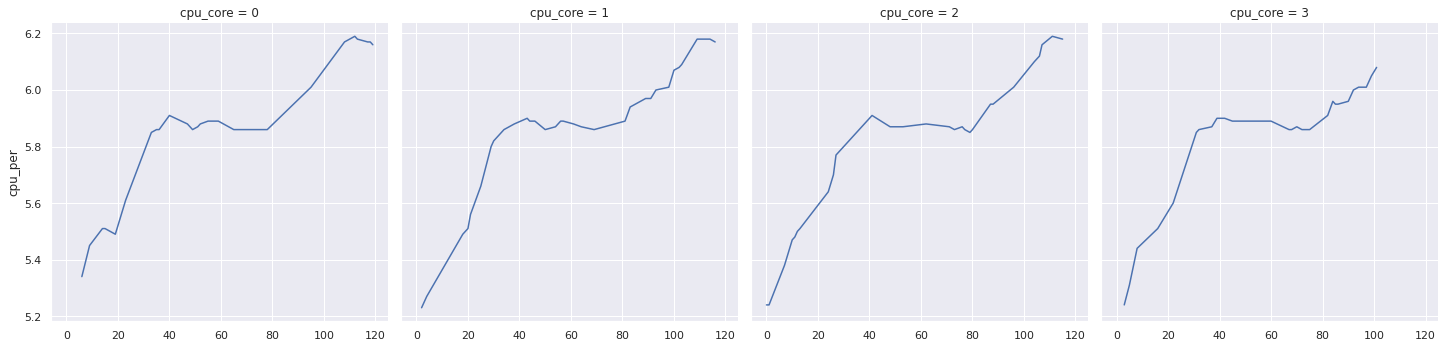

In [ ]:
sns.relplot(
    data=data,
    x=data.index, y="cpu_per", col="cpu_core",  kind="line",
    dashes=False, markers=True,
)

Como podemos ver a utilização é bem parecida entre cada core. O processo estava constantemente mudando de core durante sua utilização.

In [ ]:
# Moda
data["cpu_per"].mode()[0]

5.86

In [ ]:
# Mediana
data["cpu_per"].median()

5.87

In [ ]:
# Média
data["cpu_per"].mean()

5.838833333333333

In [ ]:
# Desvio padrão
data["cpu_per"].std()

0.2384162849512844

In [ ]:
# Coeficiente de variação
str((data["cpu_per"].std()/data["cpu_per"].median()) * 100) + ' %'

'4.061606217228014 %'

Como podemos ver com essas medidas de dispersão e tendência, não houve uma mudança muito grande no uso total da aplicação. Acredito que podemos levar como feedback para o google que o chrome está mantendo uma média de uso de cpu em seu software. Apesar do gráfico mostrar uma tendicia de subida, com o coeficiente de variação podemos ver que a "subida" não foi tão grande assim.

### Disco

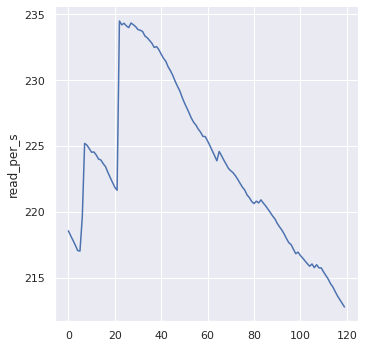

In [ ]:
sns.relplot(
    data=data,
    x=data.index, y="read_per_s",  kind="line",
    dashes=False, markers=True,
)

Aqui, por algum motivo ouve um pico de utilização no começo dos testes e depois o software diminuiu bastante tudo o que estava utilizando da vigésima amostra para o final. Era interessante ter um conjunto de amostras maior para entender se esse comportamento é cíclico ou se foi apenas um caso a parte.

### Ram

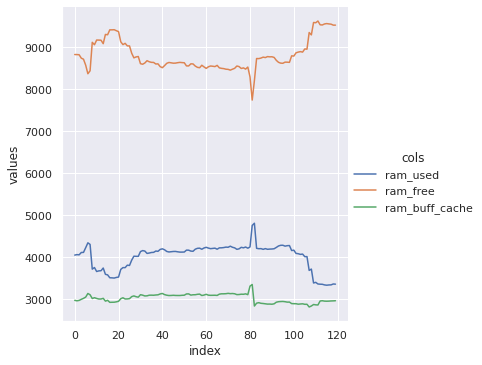

In [ ]:
data2 = data[["ram_used","ram_free", "ram_buff_cache"]].reset_index().melt('index', var_name='cols',  value_name='values')
sns.relplot(
    data=data2,
    x="index", y="values", hue='cols',
    kind="line",
)

In [ ]:
# Coeficiente de variação
str((data["ram_used"].std()/data["ram_used"].median()) * 100) + ' %'

'7.426189781015536 %'

Podemos ver aqui com esse gráfico que houve apenas um pico de utilização na amostra 80, mas no geral, não houve grandes discrepancias, vales ou subidas ingrimes. o coeficiente de variação também mostra que não tivemos um range muito grande de utilização, ela se manteve relativamente estável.

In [ ]:
str(data['ram_used'].mean()/1024) + ' GB'

'3.9272054036458335 GB'

Um ponto negativo que podemos perceber com a média dos dados obtidos de memória utilizada é que ela manteve uma média bem alta de utilização: quase 4 gb em um sistema que tem apenas 16.

## Questão 2





2. Alterando o script da questão anterior, utilize o tcpdump para capturar 100 pacotes do tipo TCP indicando a porta 22 e defina um tamanho de 60 bytes para os pacotes. Em seguida grave todas as informações em um arquivo do tipo pcap.

Script utilizado:

```
#!/bin/bash

sudo tcpdump -c 100 -i wlp2s0 -s 60 -w monitoramentoQ2.pcap tcp

echo "Done"
```

"-c 100" indica a quantidade de pacotes a serem capturados com o comando;
"-i wlp2s0" indica a interface específica para captura;
"-s 60" define o tamanho dos pacotes a serem capturados em 60 bytes;
"-w monitoramentoQ2.pcap" grava as informações capturadas em um arquivo do tipo pcap;
"tcp" restringe os tipos de pacote a serem capturados para TCP.

Obs: Tentamos indicar a porta 22, e também outras portas, mas não conseguimos fazer funcionar com a especificação.




Fluxograma 2:

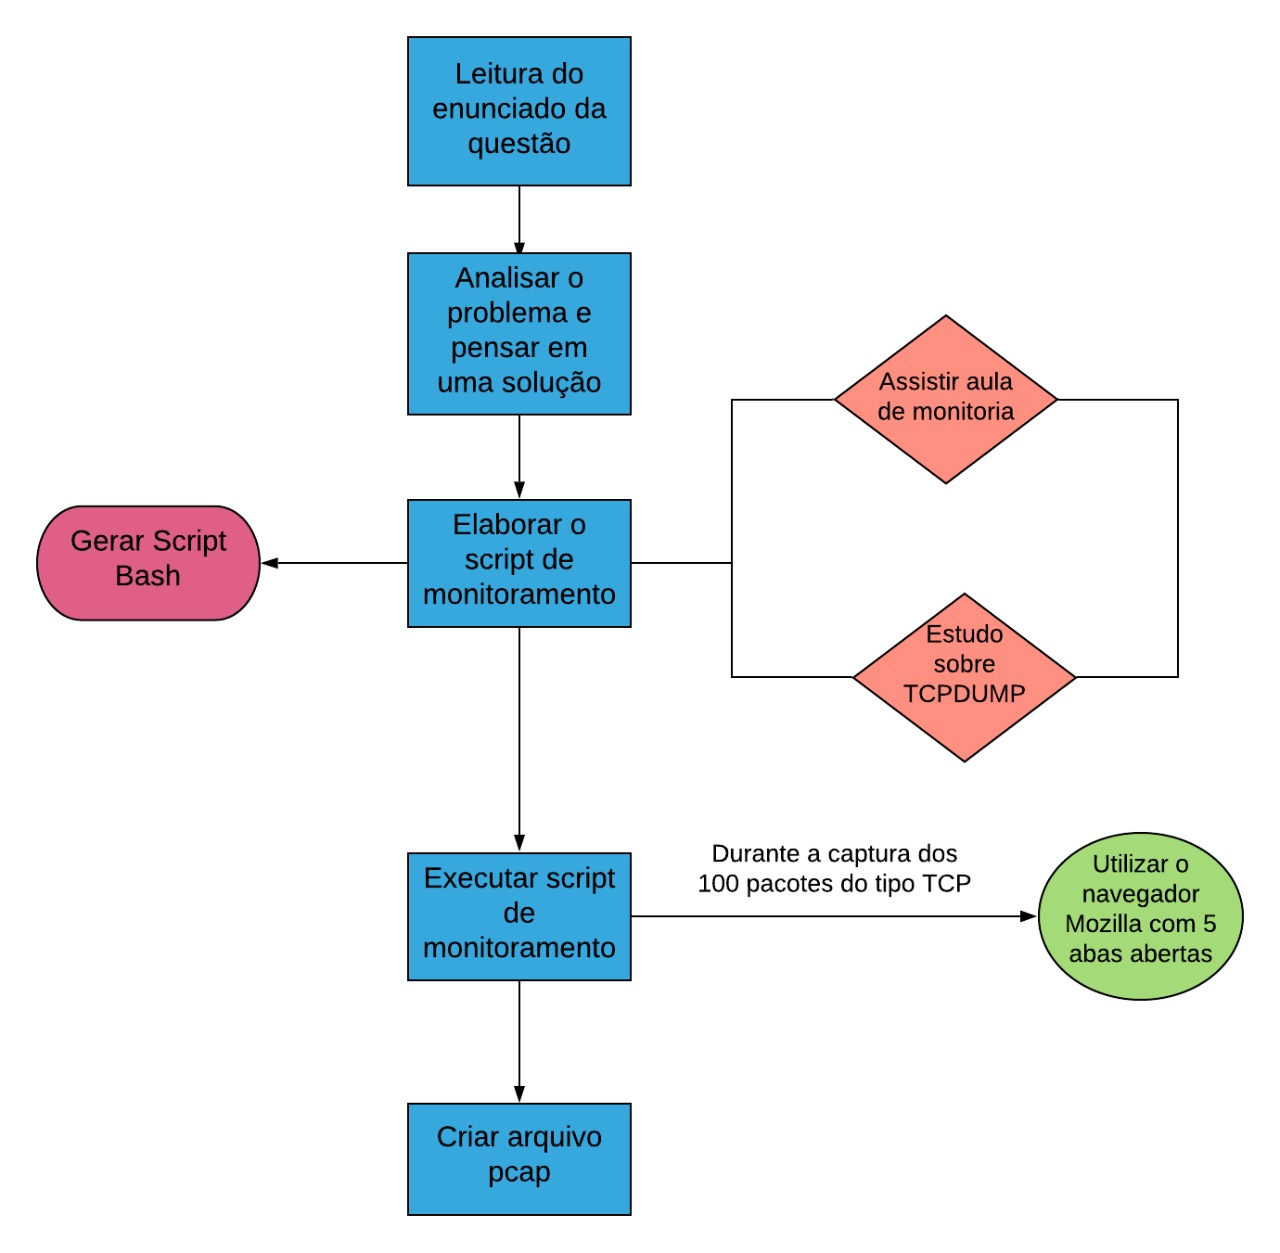